Гусев Владислав БПМИ187-1

In [0]:
%pylab inline
import matplotlib.pyplot as plt
import PIL
import numpy as np
from glob import glob
from scipy.cluster.vq import kmeans
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

Populating the interactive namespace from numpy and matplotlib
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def dist(c1, c2):
    return ((c1 - c2)**2).sum()

In [0]:
def apply_cut(img, classes, centers):
    assert len(centers) == 2
    result = img // 4
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result[x][y] += centers[classes[x][y]]
    result = np.clip(result, 0, 255)
    return result

In [0]:
def process_img(img_file, cut_func, centers, show=False):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('int64')

    centers = np.array(centers)
    classes = cut_func(img, centers)
    penalty = get_penalty(img, classes, centers)
    clustered = apply_cut(img, classes, centers)
    
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(1, 2, 1)
        plt.imshow(img)

        fig.add_subplot(1, 2, 2)
        plt.imshow(clustered)
        plt.show()

    return penalty

In [0]:
def simple_get_centers(img_file):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('float').reshape((-1, 3))
    return kmeans(img.astype('float'), 2)[0].astype('int64')

In [0]:
def get_penalty(img, classes, centers):
    assert len(centers) == 2
    result = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result += dist(img[x][y], centers[classes[x][y]])
    return result

In [0]:
def simple_cut(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if dist(img[x][y], centers[0]) < dist(img[x][y], centers[1]):
                classes[x][y] = 0
            else:
                classes[x][y] = 1
    return classes

In [0]:
import networkx as nx
from networkx.algorithms.flow import shortest_augmenting_path
def min_cut_max_flow(img, centers):
    assert len(centers) == 2
   
    G = nx.DiGraph()
   
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            G.add_edge('s',
                       (x, y),
                       capacity = np.sqrt(dist(img[x][y], centers[0])))
            G.add_edge((x, y),
                       't',
                       capacity = np.sqrt(dist(img[x][y], centers[1])))
           
            if y < img.shape[1]-1:
                G.add_edge((x, y),
                           (x, y+1),
                           capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x][y+1]))/255))
                G.add_edge((x, y+1),
                           (x, y),
                           capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x][y+1]))/255))
                if x < img.shape[0]-1:
                    G.add_edge((x, y),
                               (x+1, y),
                               capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x+1][y]))/255))
                    G.add_edge((x+1, y),
                               (x, y),
                               capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x+1][y]))/255))
            elif x < img.shape[0]-1:
                    G.add_edge((x, y),
                               (x+1, y),
                               capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x+1][y]))/255))
                    G.add_edge((x+1, y),
                               (x, y),
                               capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x+1][y]))/255))
 
    cut_value, partition = nx.minimum_cut(G, 's', 't', flow_func=shortest_augmenting_path)
    classes = np.zeros_like(img[:, :, 0])

    for i in partition[0]:
        if i != 's' and i != 't':
            classes[i[0]][i[1]] = 1
           
    for i in partition[1]:
        if i != 's' and i != 't':
            classes[i[0]][i[1]] = 0
           
    return classes

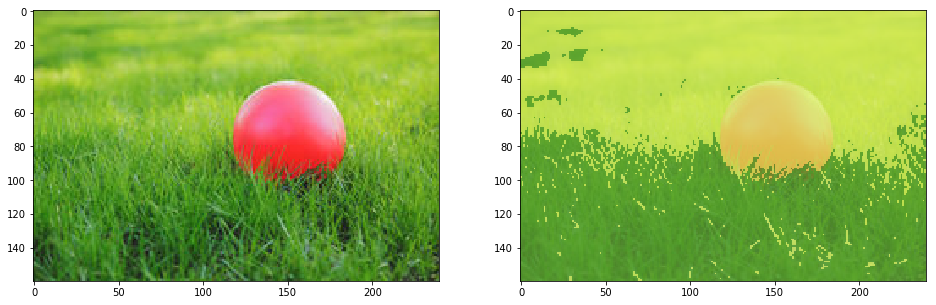

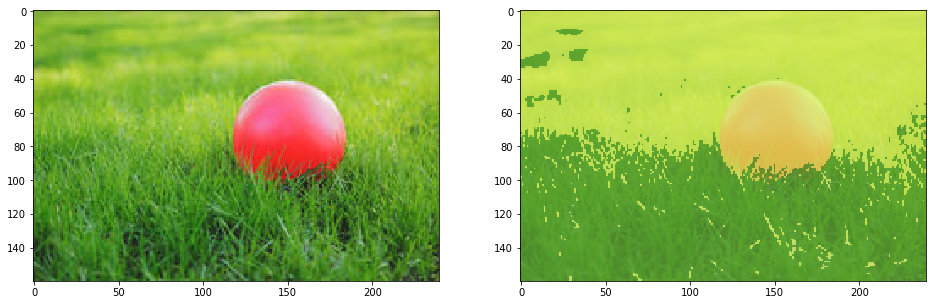

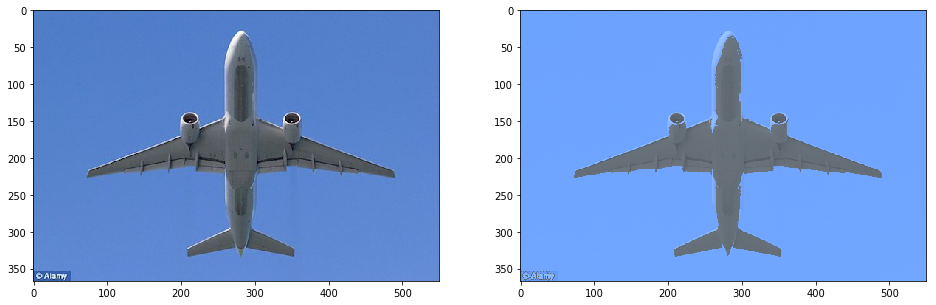

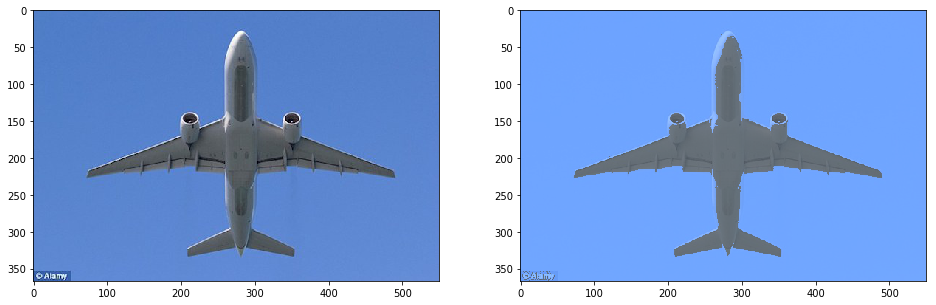

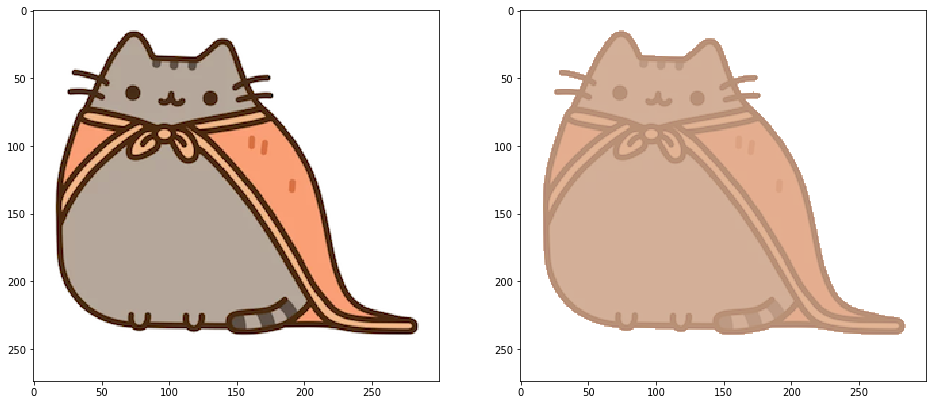

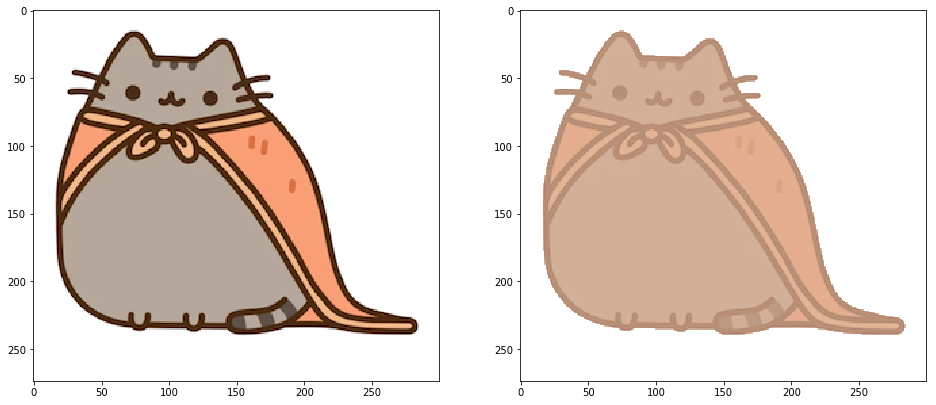

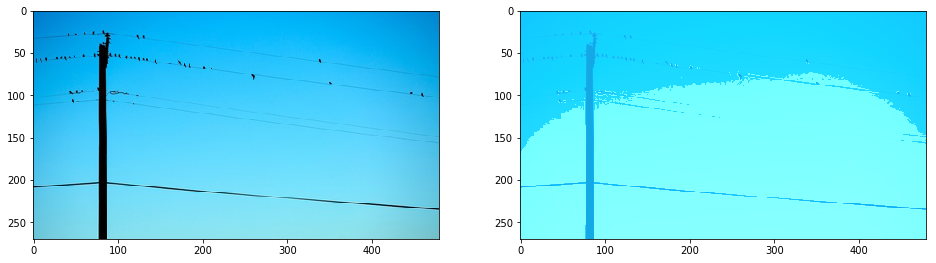

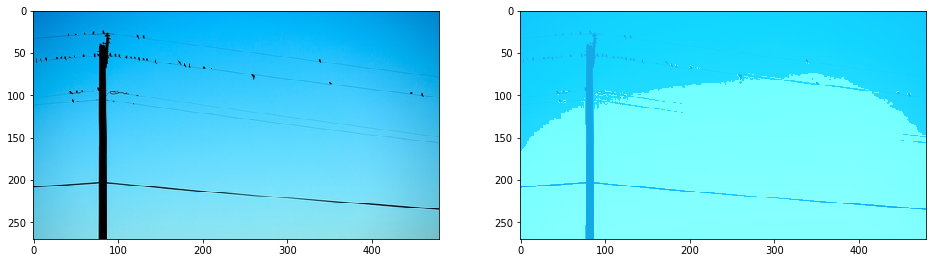

In [0]:
for img in glob('/content/drive/My Drive/AiSd_labs/AiSd_lab_hw_2/imgs/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, c, True)
    process_img(img, min_cut_max_flow, c, True)

In [0]:
#for img in glob('/content/drive/My Drive/AiSd_labs/AiSd_lab_hw_2/DIPCO2016_dataset/*'):
#    process_img(img, min_cut_max_flow, [[0, 0, 0], [255, 255, 255]], True)
# Считается макисмально долго, что можно не дождаться)
# Поэтому не стал запускать в конечном варианте.

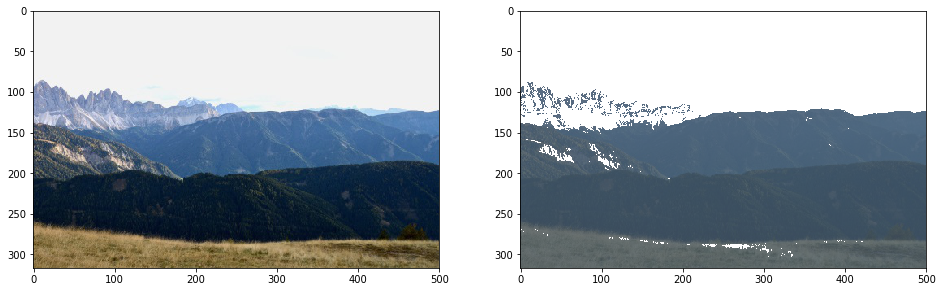

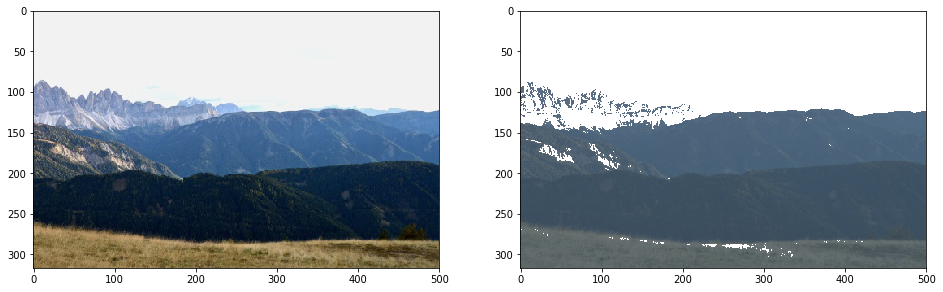

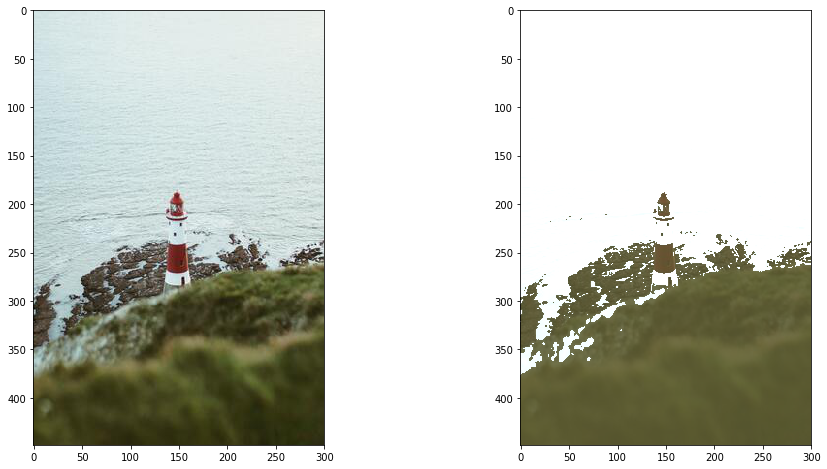

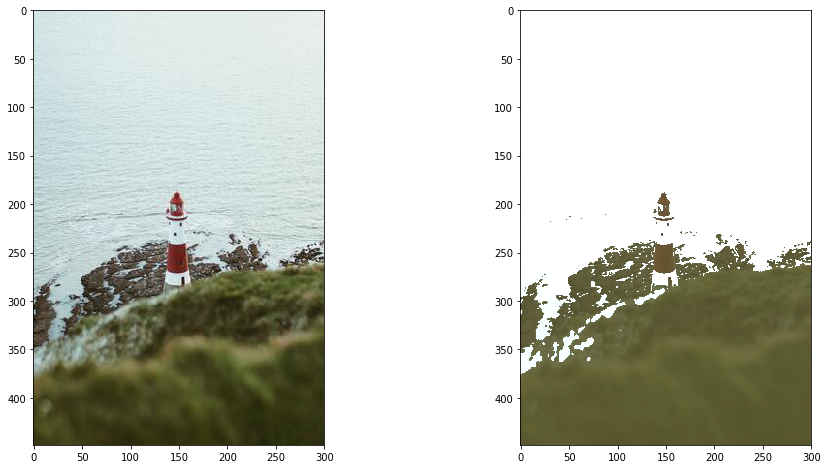

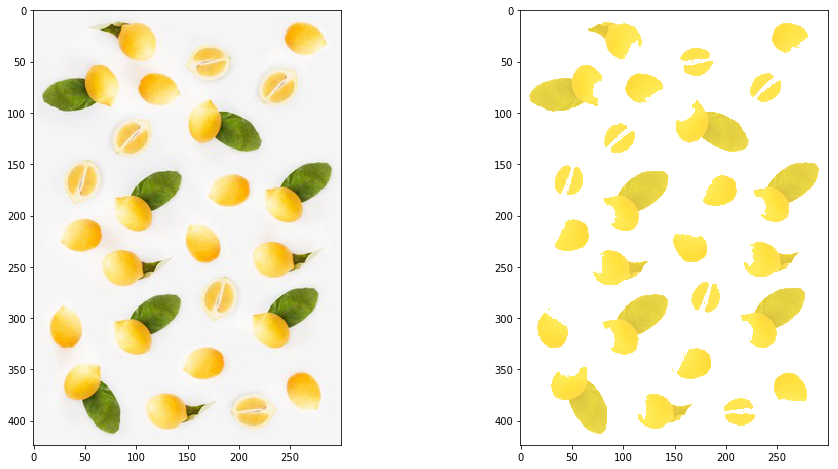

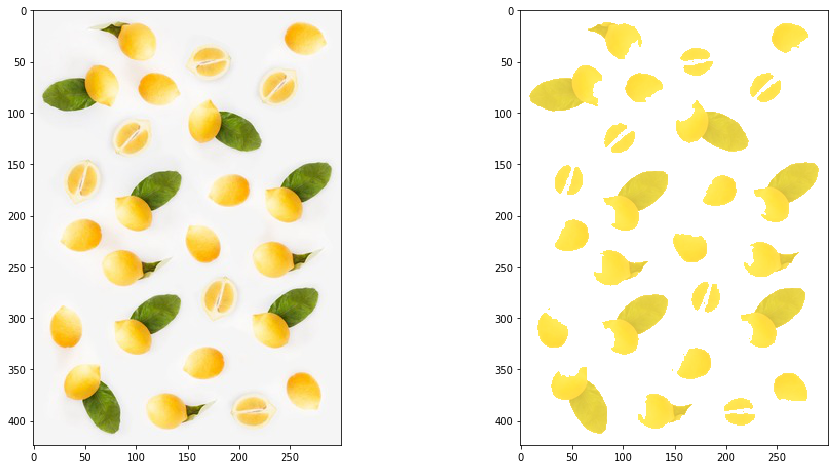

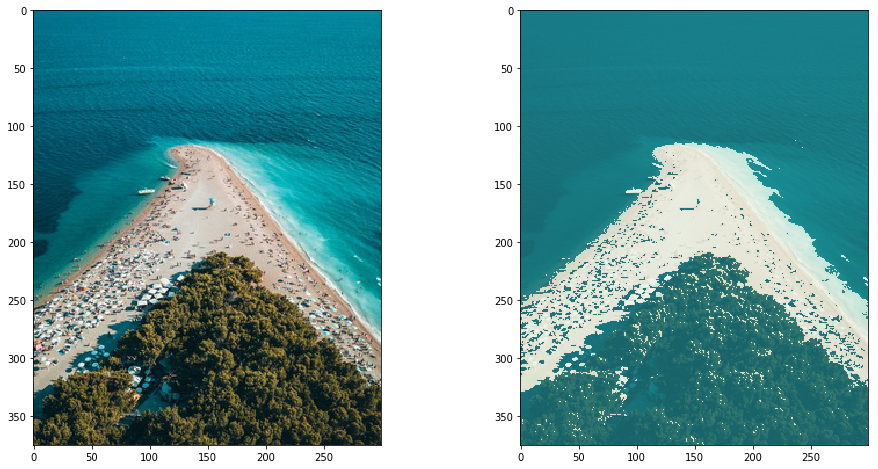

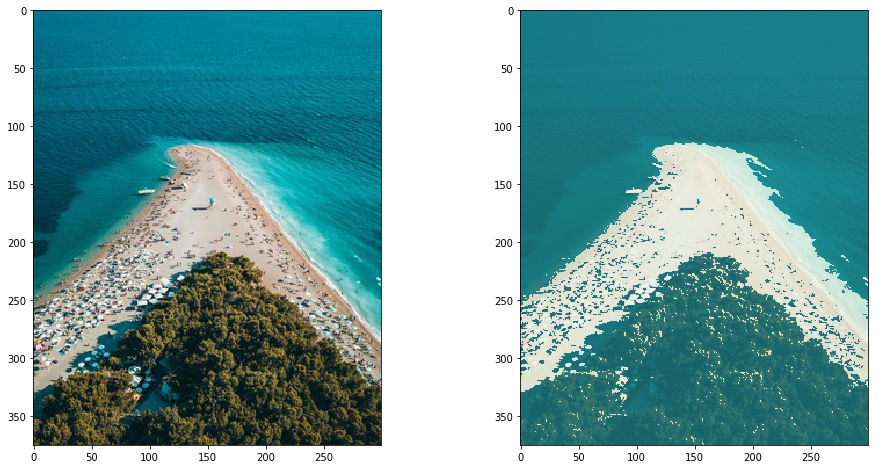

In [0]:
for img in glob('/content/drive/My Drive/AiSd_labs/AiSd_lab_hw_2/imgs_multicolor/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, c, True)
    process_img(img, min_cut_max_flow, c, True)

Теперь напишу свою функцию:

In [0]:
from collections import defaultdict, deque

In [0]:
def dist(c1, c2):
    return ((c1 - c2)**2).sum() ** 0.5

In [0]:
def get_penalty(img, classes, centers, penalty_coefs=(1,1)):
    assert len(centers) == 2
    result = np.array([0.0, 0.0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result[0] += dist(img[x][y], centers[classes[x][y]])
            if x < img.shape[0] - 1 and classes[x][y] != classes[x+1][y]:
                result[1] += edge_penalty(img[x][y], img[x+1][y])
            if y < img.shape[1] - 1 and classes[x][y] != classes[x][y+1]:
                result[1] += edge_penalty(img[x][y], img[x][y+1])
    return (result * penalty_coefs).sum()

In [0]:
def edge_penalty(c1, c2):
    return 1 / (1 + dist(c1, c2) / 255)

In [0]:
def apply_cut(img, classes, centers, klass=1):
    assert len(centers) == 2
    result = img // 1
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if classes[x][y] == klass:
                 pass
            else:
                result[x][y] = [255, 255, 255]
    result = np.clip(result, 0, 255)
    return result

In [0]:
def process_img(img_file, cut_func, centers, show=False, penalty_coefs=(1,1)):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('int64')

    centers = np.array(centers)
    classes = cut_func(img, centers, penalty_coefs)
    penalty = get_penalty(img, classes, centers, penalty_coefs)
    first_clustered = apply_cut(img, classes, centers, 0)
    second_clustered = apply_cut(img, classes, centers, 1)
    
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(221)
        plt.imshow(img)

        fig.add_subplot(223)
        plt.imshow(first_clustered)
        
        fig.add_subplot(224)
        plt.imshow(second_clustered)
        plt.show()

    return (penalty, classes)

In [0]:
def simple_get_centers(img_file):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('float').reshape((-1, 3))
    return kmeans(img.astype('float'), 2)[0].astype('int64')

In [0]:
def simple_cut(img, centers, coefs):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if dist(img[x][y], centers[0]) < dist(img[x][y], centers[1]):
                classes[x][y] = 0
            else:
                classes[x][y] = 1
    return classes

In [0]:
#Алгоритм Диница
def min_cut(img, centers, coefs=(1,1)):
    def find_levels():
        q = deque()
        q.append('source')
        levels['source'] = 0
        while len(q) > 0:
            cur = q.popleft()
            for v in graph[cur]:
                if levels[v] == -1 and graph[cur][v] > 0:
                    q.append(v)
                    levels[v] = levels[cur] + 1
        return levels['sink'] >= 0
    
    def send_flow(u, flow=math.inf):
        if u == 'sink' or flow == 0:
            return flow
        keys = [*graph[u].keys()]
        while start[u] < len(graph[u]):
            v = keys[start[u]]
            if (levels[v] == levels[u] + 1 and graph[u][v] > 0):
                cur_flow = min(flow, graph[u][v])
                temp_flow = send_flow(v, cur_flow)
                if temp_flow > 0:
                    graph[u][v] -= temp_flow
                    graph[v][u] += temp_flow
                    return temp_flow
            start[u] += 1
        return 0
    
    def build_classes():
        classes = np.zeros_like(img[:, :, 0])
        visited = defaultdict(lambda: False)
        q = deque()
        q.append('source')
        visited['source'] = True
        while len(q) > 0:
            cur = q.popleft()
            for v in graph[cur]:
                if not visited[v] and graph[cur][v] > 0:
                    q.append(v)
                    visited[v] = True
                    classes[v[0]][v[1]] = 1
        return classes
    
    graph = defaultdict(lambda: defaultdict(lambda: 0.0))
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if x - 1 >= 0:
                graph[(x,y)][(x-1,y)] = edge_penalty(img[x][y], img[x-1][y]) * coefs[1]
            if x + 1 < img.shape[0]:
                graph[(x,y)][(x+1,y)] = edge_penalty(img[x][y], img[x+1][y]) * coefs[1]
            if y - 1 >= 0:
                graph[(x,y)][(x,y-1)] = edge_penalty(img[x][y], img[x][y-1]) * coefs[1]
            if y + 1 < img.shape[1]:
                graph[(x,y)][(x,y+1)] = edge_penalty(img[x][y], img[x][y+1]) * coefs[1]
            graph['source'][(x,y)] = dist(img[x][y], centers[0]) * coefs[0]
            graph[(x,y)]['sink'] = dist(img[x][y], centers[1]) * coefs[0]
    
    levels = defaultdict(lambda: -1)
    while find_levels():
        start = defaultdict(int)
        flow = send_flow('source')
        while flow > 0:
            flow = send_flow('source')
        levels = defaultdict(lambda: -1)

    return build_classes()

In [0]:
def process_img1(img, cut_func, c, coefs=(1,1)):
    simple_cut_penalty, simple_cut_classes = process_img(img, simple_cut, c, coefs)
    cut_penalty, cut_classes = process_img(img, cut_func, c, show, coefs)
    return [(simple_cut_penalty, simple_cut_classes), (cut_penalty, cut_classes)]

Saving imgonline-com-ua-Resize-RGjUByqi7SX4.jpg to imgonline-com-ua-Resize-RGjUByqi7SX4.jpg


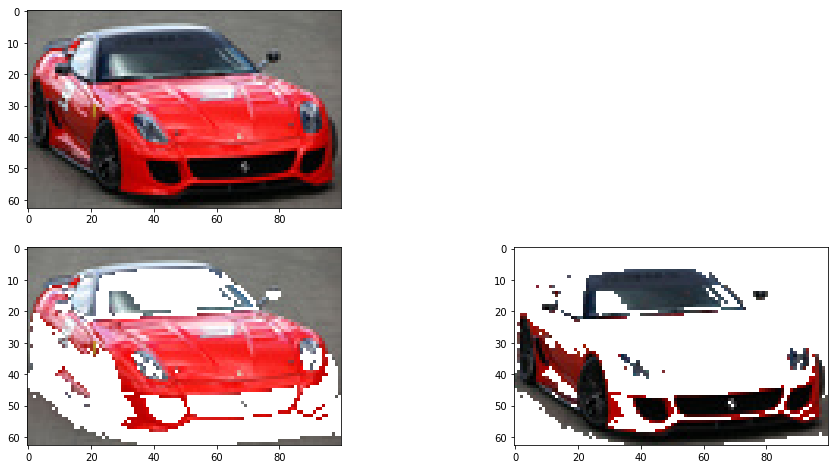

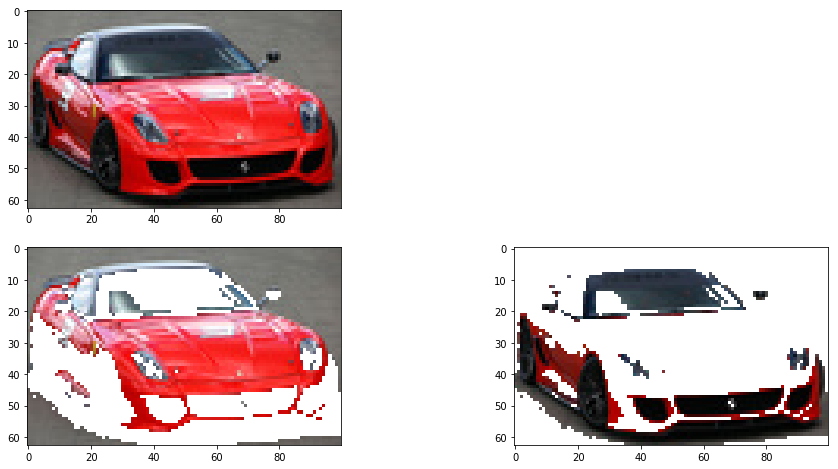

In [0]:
imgss = files.upload()
for img in imgss:
    c = simple_get_centers(img)
    process_img1(img, min_cut, c)

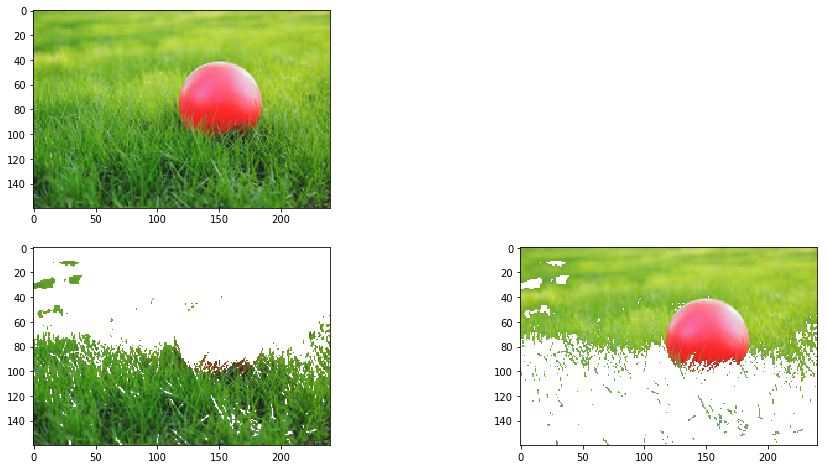

KeyboardInterrupt: ignored

In [0]:
for img in glob('/content/drive/My Drive/AiSd_labs/AiSd_lab_hw_2/imgs/*'):
    if img != 'imgs/test2.jpg':
        c = simple_get_centers(img)
        process_img1(img, min_cut, c)

In [0]:
imgss = files.upload()
#for img in glob('/content/drive/My Drive/AiSd_labs/AiSd_lab_hw_2/my_tests/*'):
for img in imgss:
#    c = simple_get_centers(img)
#    process_img(img, simple_cut, c, True)
#    process_img(img, new_cut_func, c, True)
    c = simple_get_centers(img)
    process_img(img, simple_cut, c, True)
    process_img(img, new_cut_func, c, True)